In [1]:
import cv2
import time
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import lsqr
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
import os

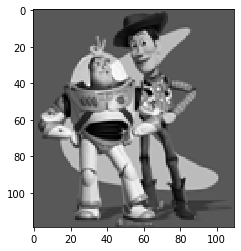

In [2]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2RGB)
toy_img = cv2.cvtColor(toy_img, cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")

## Part 1 Toy Problem (20 pts)

In [78]:
def toy_reconstruct(toy_img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    im=toy_img
    im_h, im_w = toy_img.shape
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    num_v = (im_h)*(im_w)
    num_e = im_h*(im_w-1) + im_w*(im_h-1) + 1
    #A = np.zeros((num_e,num_v))
    A = lil_matrix((num_e,num_v))
    b = np.zeros((num_e,))
    e=0
    for x in range(im_w):
        for y in range(im_h):
            if x < im_w-1:
                A[e,im2var[y][x+1]] = 1
                A[e,im2var[y][x]] = -1
                b[e] = im[y][x+1] - im[y][x]
                e+=1
            if y < im_h-1:
                A[e,im2var[y+1][x]] = 1
                A[e,im2var[y][x]] = -1
                b[e] = im[y+1][x] - im[y][x]
                e+=1
            
    A[e,im2var[0][0]] = 1
    b[e] = im[0][0]
    A=A.tocsr()
    v = lsqr(A, b)
    
    return v[0].reshape((im_w, im_h)).T
            

Error is:  0.00031701850068623744


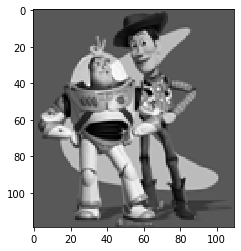

In [79]:
im_out = toy_reconstruct(toy_img)

if im_out.any():
    print("Error is: ", np.sqrt(((im_out - toy_img)**2).sum()))

plt.close()
plt.imshow(im_out, cmap="gray")

## Preparation

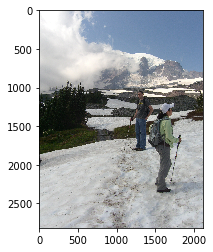

In [5]:
# Feel free to change image
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


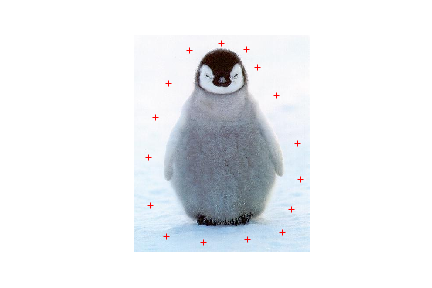

In [7]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

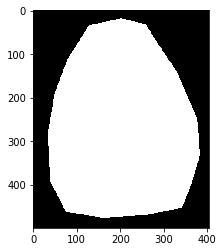

In [8]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


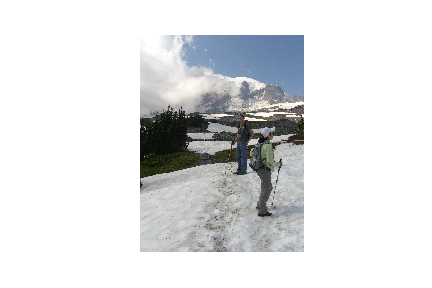

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

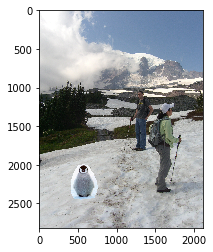

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)

## Part 2 Poisson Blending (50 pts)

In [2]:
def hms(secs):
    hours = int(secs/3600.)
    remain = secs - hours*3600
    mins = int(remain/60.)
    remain = int(remain - mins*60)
    return (hours, mins, remain)
    

In [3]:
def poisson_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    #TO DO 
    #idx is the list of x, y coordinates that are in the mask
    idx = np.where(object_mask==1)
    idx = np.concatenate((idx[0].reshape(-1,1),idx[1].reshape(-1,1)),axis=1)

    s=cropped_object
    t=background_img
    
    im_h, im_w, _ = t.shape
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    num_v = im_h*im_w
    num_e = np.where(object_mask==1)[0].shape[0] * 5
    return_v = np.zeros(t.shape)
    
    for c in range(3):
        #A = csr_matrix((num_e,num_v))
        A = lil_matrix((num_e,num_v))
        b = np.zeros((num_e,))
        e=0
        tick = time.time()
        for x in range(im_w):
            for y in range(im_h):
                if object_mask[y][x]==1:
                    if x < im_w-1:
                        A[e,im2var[y][x+1]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = s[y][x][c] - s[y][x+1][c]
                        e+=1
                    if y < im_h-1:
                        A[e,im2var[y+1][x]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = s[y][x][c] - s[y+1][x][c]
                        e+=1
                    if x > 0:
                        A[e,im2var[y][x-1]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = s[y][x][c] - s[y][x-1][c]
                        e+=1
                    if y > 0:
                        A[e,im2var[y-1][x]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = s[y][x][c] - s[y-1][x][c]
                        e+=1
                    if object_mask[y][x+1]==0:
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y][x+1][c] + s[y][x][c] - s[y][x+1][c]
                        e+=1
                    if object_mask[y][x-1]==0:
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y][x-1][c] + s[y][x][c] - s[y][x-1][c]
                        e+=1
                    if object_mask[y+1][x]==0:
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y+1][x][c] + s[y][x][c] - s[y+1][x][c]
                        e+=1
                    if object_mask[y-1][x]==0:
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y-1][x][c] + s[y][x][c] - s[y-1][x][c]
                        e+=1
        tock = time.time()
        hr, mn, sc = hms(tock-tick)
        print(f'Equations for channel {c} took {hr} hours, {mn} minutes, and {sc} seconds')
        
        tick = time.time()             
        A=A.tocsr()
        A=csr_matrix(A)
        A=A[:e,:]
        b=b[:e]
        tock = time.time()
        hr, mn, sc = hms(tock-tick)
        print(f'Segmenting for channel {c} took {hr} hours, {mn} minutes, and {sc} seconds')
        
        tick = time.time()
        v = lsqr(A, b)
        tock = time.time()
        hr, mn, sc = hms(tock-tick)
        print(f'LSQR for channel {c} took {hr} hours, {mn} minutes, and {sc} seconds')
        
        
        return_v[:,:,c] = v[0].reshape((im_w, im_h)).T
    
    d3_mask = np.stack((object_mask,object_mask,object_mask),axis=2)
    return_v = background_img*(1-d3_mask) + return_v*d3_mask
    return_v[return_v > 1] = 1.
    return_v[return_v < 0] = 0.
    
    return return_v

Equations for channel 0 took 0 hours, 0 minutes, and 10 seconds
Segmenting for channel 0 took 0 hours, 0 minutes, and 0 seconds
(505756, 5947392)
(505756,)
5947392
505756
LSQR for channel 0 took 0 hours, 1 minutes, and 43 seconds
Equations for channel 1 took 0 hours, 0 minutes, and 10 seconds
Segmenting for channel 1 took 0 hours, 0 minutes, and 0 seconds
(505756, 5947392)
(505756,)
5947392
505756
LSQR for channel 1 took 0 hours, 1 minutes, and 42 seconds
Equations for channel 2 took 0 hours, 0 minutes, and 10 seconds
Segmenting for channel 2 took 0 hours, 0 minutes, and 0 seconds
(505756, 5947392)
(505756,)
5947392
505756
LSQR for channel 2 took 0 hours, 1 minutes, and 43 seconds
Total time took 0 hours, 5 minutes, and 43 seconds


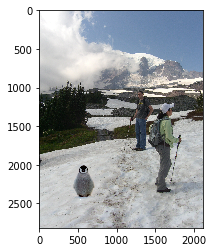

In [13]:
tickt = time.time()
im_blend = poisson_blend(cropped_object, object_mask, background_img)
if im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend)
tockt = time.time()

h, m, s = hms(tockt-tickt)

print(f'Total time took {h} hours, {m} minutes, and {s} seconds')

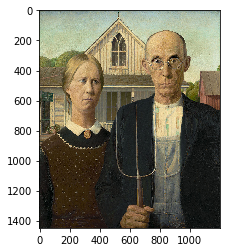

In [3]:
background_img = cv2.cvtColor(cv2.imread('samples/farmer.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.close()
plt.imshow(background_img)

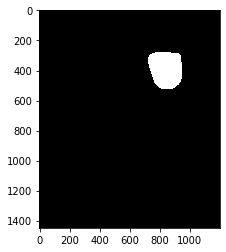

In [4]:
object_mask = cv2.cvtColor(cv2.imread('samples/face_mask.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_mask = np.mean(object_mask,axis=2)
object_mask[object_mask >= 0.5] = 1.
object_mask[object_mask < 0.5] = 0.
plt.close()
plt.imshow(object_mask,cmap='gray')

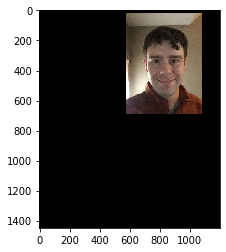

In [5]:
foreground_img = cv2.cvtColor(cv2.imread('samples/smile_cropped.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.close()
plt.imshow(foreground_img)

Equations for channel 0 took 0 hours, 0 minutes, and 1 seconds
Segmenting for channel 0 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 0 took 0 hours, 0 minutes, and 16 seconds
Equations for channel 1 took 0 hours, 0 minutes, and 1 seconds
Segmenting for channel 1 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 1 took 0 hours, 0 minutes, and 16 seconds
Equations for channel 2 took 0 hours, 0 minutes, and 2 seconds
Segmenting for channel 2 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 2 took 0 hours, 0 minutes, and 16 seconds
Total time took 0 hours, 0 minutes, and 57 seconds


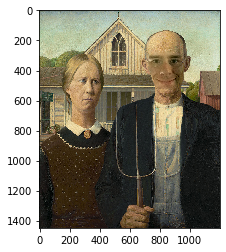

In [9]:
tickt = time.time()
im_blend = poisson_blend(foreground_img, object_mask, background_img)
if im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend)
tockt = time.time()

h, m, s = hms(tockt-tickt)

print(f'Total time took {h} hours, {m} minutes, and {s} seconds')

In [10]:
plt.imsave('smile_farmer.jpg',im_blend)

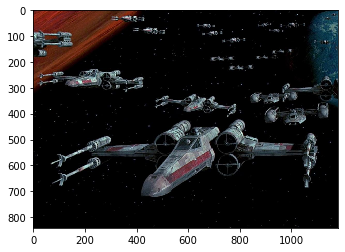

In [11]:
background_img = cv2.cvtColor(cv2.imread('samples/xwings.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.close()
plt.imshow(background_img)

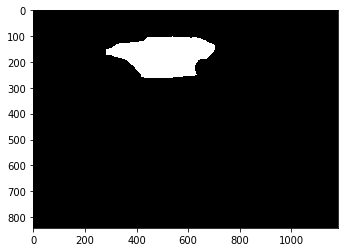

In [12]:
object_mask = cv2.cvtColor(cv2.imread('samples/enterprise_mask.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_mask = np.mean(object_mask,axis=2)
object_mask[object_mask >= 0.5] = 1.
object_mask[object_mask < 0.5] = 0.
plt.close()
plt.imshow(object_mask,cmap='gray')

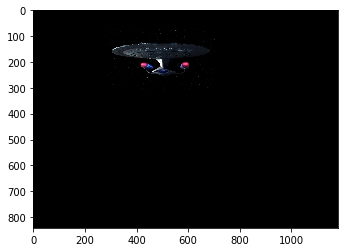

In [13]:
foreground_img = cv2.cvtColor(cv2.imread('samples/enterprise_cropped.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.close()
plt.imshow(foreground_img)

Equations for channel 0 took 0 hours, 0 minutes, and 1 seconds
Segmenting for channel 0 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 0 took 0 hours, 0 minutes, and 8 seconds
Equations for channel 1 took 0 hours, 0 minutes, and 1 seconds
Segmenting for channel 1 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 1 took 0 hours, 0 minutes, and 8 seconds
Equations for channel 2 took 0 hours, 0 minutes, and 1 seconds
Segmenting for channel 2 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 2 took 0 hours, 0 minutes, and 8 seconds
Total time took 0 hours, 0 minutes, and 32 seconds


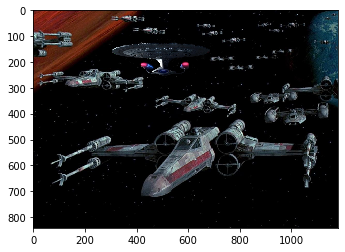

In [14]:
tickt = time.time()
im_blend = poisson_blend(foreground_img, object_mask, background_img)
if im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend)
tockt = time.time()

h, m, s = hms(tockt-tickt)

print(f'Total time took {h} hours, {m} minutes, and {s} seconds')

In [15]:
plt.imsave('enterprise_xwings.jpg',im_blend)

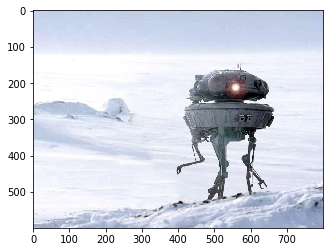

In [4]:
background_img = cv2.cvtColor(cv2.imread('samples/probe.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.close()
plt.imshow(background_img)

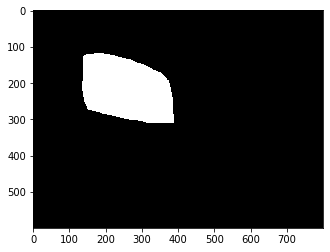

In [5]:
object_mask = cv2.cvtColor(cv2.imread('samples/polar_bear_mask_fail.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_mask = np.mean(object_mask,axis=2)
object_mask[object_mask >= 0.5] = 1.
object_mask[object_mask < 0.5] = 0.
plt.close()
plt.imshow(object_mask,cmap='gray')

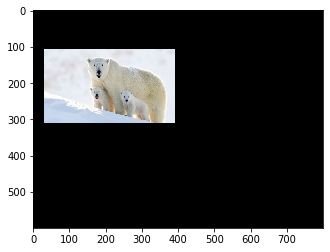

In [6]:
foreground_img = cv2.cvtColor(cv2.imread('samples/polar_bear_cropped.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.close()
plt.imshow(foreground_img)

Equations for channel 0 took 0 hours, 0 minutes, and 1 seconds
Segmenting for channel 0 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 0 took 0 hours, 0 minutes, and 3 seconds
Equations for channel 1 took 0 hours, 0 minutes, and 1 seconds
Segmenting for channel 1 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 1 took 0 hours, 0 minutes, and 3 seconds
Equations for channel 2 took 0 hours, 0 minutes, and 1 seconds
Segmenting for channel 2 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 2 took 0 hours, 0 minutes, and 3 seconds
Total time took 0 hours, 0 minutes, and 16 seconds


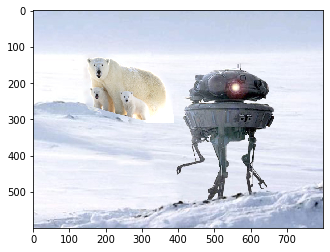

In [7]:
tickt = time.time()
im_blend = poisson_blend(foreground_img, object_mask, background_img)
if im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend)
tockt = time.time()

h, m, s = hms(tockt-tickt)

print(f'Total time took {h} hours, {m} minutes, and {s} seconds')

In [8]:
plt.imsave('polar_droid_fail.jpg',im_blend)

## Part 3 Mixed Gradients (20 pts)

<IPython.core.display.Javascript object>


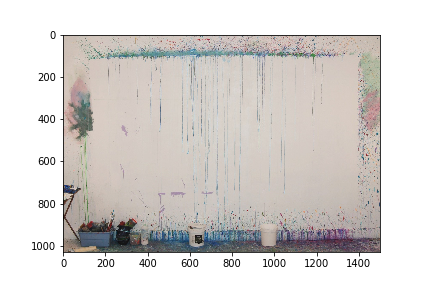

In [16]:
background_img = cv2.cvtColor(cv2.imread('samples/street.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


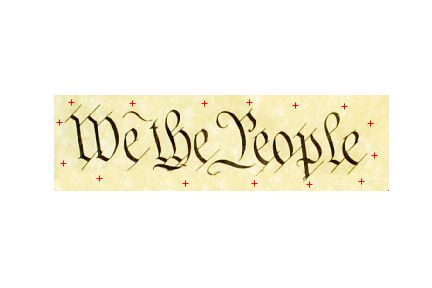

In [13]:
object_img = cv2.cvtColor(cv2.imread('samples/we_the_people2.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

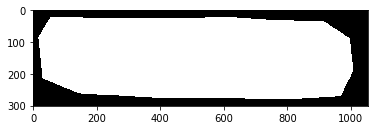

In [14]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


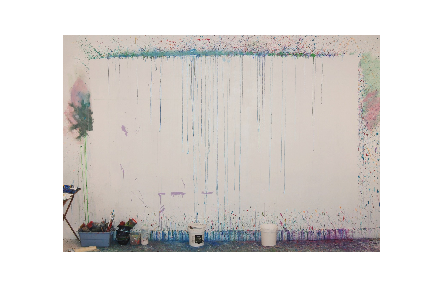

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

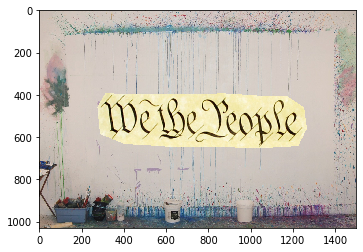

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)

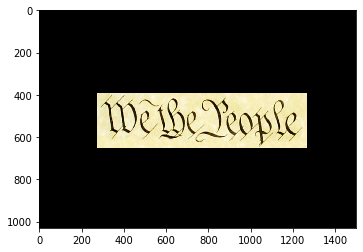

In [19]:
plt.close()
plt.imshow(cropped_object)
plt.imsave('samples/we_the_people_cropped.jpg',cropped_object)

In [20]:
def mix_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    idx = np.where(object_mask==1)
    idx = np.concatenate((idx[0].reshape(-1,1),idx[1].reshape(-1,1)),axis=1)

    s=cropped_object
    t=background_img
    
    im_h, im_w, _ = t.shape
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    num_v = im_h*im_w
    num_e = np.where(object_mask==1)[0].shape[0] * 5
    return_v = np.zeros(t.shape)
    
    for c in range(3):
        #A = csr_matrix((num_e,num_v))
        A = lil_matrix((num_e,num_v))
        b = np.zeros((num_e,))
        e=0
        tick = time.time()
        for x in range(im_w):
            for y in range(im_h):
                if object_mask[y][x]==1:
                    if x < im_w-1:
                        si = s[y][x][c] - s[y][x+1][c]
                        ti = t[y][x][c] - t[y][x+1][c]
                        if np.absolute(si) > np.absolute(ti):
                            d = si
                        else:
                            d = ti
                            
                        A[e,im2var[y][x+1]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = d
                        e+=1
                    if y < im_h-1:
                        si = s[y][x][c] - s[y+1][x][c]
                        ti = t[y][x][c] - t[y+1][x][c]
                        if np.absolute(si) > np.absolute(ti):
                            d = si
                        else:
                            d = ti
                        
                        A[e,im2var[y+1][x]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = d
                        e+=1
                    if x > 0:
                        si = s[y][x][c] - s[y][x-1][c]
                        ti = t[y][x][c] - t[y][x-1][c]
                        if np.absolute(si) > np.absolute(ti):
                            d = si
                        else:
                            d = ti
                        
                        A[e,im2var[y][x-1]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = d
                        e+=1
                    if y > 0:
                        si = s[y][x][c] - s[y-1][x][c]
                        ti = t[y][x][c] - t[y-1][x][c]
                        if np.absolute(si) > np.absolute(ti):
                            d = si
                        else:
                            d = ti
                        
                        A[e,im2var[y-1][x]] = -1
                        A[e,im2var[y][x]] = 1
                        b[e] = d
                        e+=1
                    if object_mask[y][x+1]==0:
                        si = s[y][x][c] - s[y][x+1][c]
                        ti = t[y][x][c] - t[y][x+1][c]
                        if np.absolute(si) > np.absolute(ti):
                            d = si
                        else:
                            d = ti
                        
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y][x+1][c] + d
                        e+=1
                    if object_mask[y][x-1]==0:
                        si = s[y][x][c] - s[y][x-1][c]
                        ti = t[y][x][c] - t[y][x-1][c]
                        if np.absolute(si) > np.absolute(ti):
                            d = si
                        else:
                            d = ti
                        
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y][x-1][c] + d
                        e+=1
                    if object_mask[y+1][x]==0:
                        si = s[y][x][c] - s[y+1][x][c]
                        ti = t[y][x][c] - t[y+1][x][c]
                        if np.absolute(si) > np.absolute(ti):
                            d = si
                        else:
                            d = ti
                        
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y+1][x][c] + d
                        e+=1
                    if object_mask[y-1][x]==0:
                        si = s[y][x][c] - s[y-1][x][c]
                        ti = t[y][x][c] - t[y-1][x][c]
                        if np.absolute(si) > np.absolute(ti):
                            d = si
                        else:
                            d = ti
                            
                        A[e,im2var[y][x]] = 1
                        b[e] = t[y-1][x][c] + s[y][x][c] - s[y-1][x][c]
                        e+=1
        tock = time.time()
        hr, mn, sc = hms(tock-tick)
        print(f'Equations for channel {c} took {hr} hours, {mn} minutes, and {sc} seconds')
        
        tick = time.time()             
        A=A.tocsr()
        A=A[:e,:]
        b=b[:e]
        tock = time.time()
        hr, mn, sc = hms(tock-tick)
        print(f'Segmenting for channel {c} took {hr} hours, {mn} minutes, and {sc} seconds')
        
        tick = time.time()
        v = lsqr(A, b)
        tock = time.time()
        hr, mn, sc = hms(tock-tick)
        print(f'LSQR for channel {c} took {hr} hours, {mn} minutes, and {sc} seconds')
        
        
        return_v[:,:,c] = v[0].reshape((im_w, im_h)).T
    
    d3_mask = np.stack((object_mask,object_mask,object_mask),axis=2)
    return_v = background_img*(1-d3_mask) + return_v*d3_mask
    return_v[return_v > 1] = 1.
    return_v[return_v < 0] = 0.
    
    return return_v

Equations for channel 0 took 0 hours, 0 minutes, and 12 seconds
Segmenting for channel 0 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 0 took 0 hours, 0 minutes, and 38 seconds
Equations for channel 1 took 0 hours, 0 minutes, and 12 seconds
Segmenting for channel 1 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 1 took 0 hours, 0 minutes, and 38 seconds
Equations for channel 2 took 0 hours, 0 minutes, and 12 seconds
Segmenting for channel 2 took 0 hours, 0 minutes, and 0 seconds
LSQR for channel 2 took 0 hours, 0 minutes, and 37 seconds


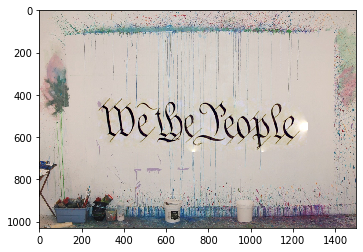

In [40]:
im_mix = mix_blend(cropped_object, object_mask, background_img)
if im_mix.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_mix)

In [41]:
plt.imsave('we_the_people1.jpg',im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [141]:
def color2gray(clr_img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    im=clr_img
    im_h, im_w, im_c = im.shape
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T
    num_v = (im_h)*(im_w)
    num_e = im_h*(im_w-1) + im_w*(im_h-1) + 1
    #A = np.zeros((num_e,num_v))
    A = lil_matrix((num_e,num_v))
    b = np.zeros((num_e,))
    e=0
    for x in range(im_w):
        for y in range(im_h):
            if x < im_w-1:
                d = im[y,x+1,:] - im[y,x,:]
                d = max(d.min(), d.max(), key=abs)
                A[e,im2var[y][x+1]] = 1
                A[e,im2var[y][x]] = -1
                b[e] = d
                e+=1
            if y < im_h-1:
                d = im[y+1,x,:] - im[y,x,:]
                d = max(d.min(), d.max(), key=abs)
                A[e,im2var[y+1][x]] = 1
                A[e,im2var[y][x]] = -1
                b[e] = d
                e+=1
            
    A[e,im2var[0][0]] = 1
    b[e] = np.mean(im[0,0,:])
    A=A.tocsr()
    v = lsqr(A, b)
    v[0][v[0] > 1] = 1.
    v[0][v[0] < 0] = 0.
    return v[0].reshape((im_w, im_h)).T

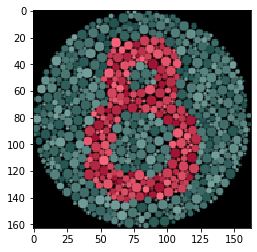

In [143]:
clr_img = cv2.cvtColor(cv2.imread('samples/colorBlind8.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.imshow(clr_img)

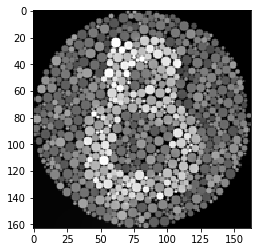

In [144]:
gray_img = color2gray(clr_img)
plt.close()
plt.imshow(gray_img,cmap='gray')
im_save = np.stack((gray_img,gray_img,gray_img),axis=2)
plt.imsave('gray_colorblind8.jpg',im_save)

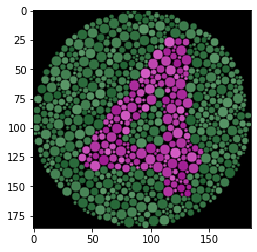

In [127]:
clr_img = cv2.cvtColor(cv2.imread('samples/colorBlind4.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.close()
plt.imshow(clr_img)


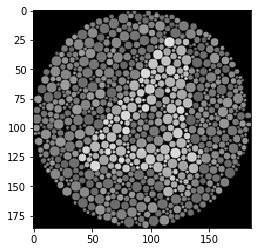

In [142]:
gray_img = color2gray(clr_img)
plt.close()
plt.imshow(gray_img,cmap='gray')
im_save = np.stack((gray_img,gray_img,gray_img),axis=2)
plt.imsave('gray_colorblind4.jpg',im_save)

## Laplacian pyramid blending (20 pts)

In [29]:
def blur_img(img,kernel_size=None):
    #sigma_low = 1./(2*np.pi*cutoff_low)
    kernel = cv2.getGaussianKernel(kernel_size,-1)
    kernel = np.dot(kernel,kernel.T)
    blur_img = cv2.filter2D(img, -1, kernel)
    
    
    #if kernel_size is None:
    #    kernel_size = int(min(img.shape[0],img.shape[1])/15)
    #if kernel_size % 2 == 0:
    #    kernel_size += 1
    #blur_img = cv2.GaussianBlur(img,(kernel_size,kernel_size),cv2.BORDER_DEFAULT)
    
    
    
    
    
    return blur_img

In [55]:
def laplacian_blend(img1, img2, mask):
    L10 = img1 - blur_img(img1,kernel_size=25)
    L20 = img2 - blur_img(img2,kernel_size=25)
    mask_L0 = blur_img(mask,kernel_size=5)
    mask_L0 = np.stack((mask_L0,mask_L0,mask_L0),axis=2)
    L0 = L20 * mask_L0 + L10 * (1-mask_L0)
    L11 = blur_img(img1,kernel_size=25)
    L21 = blur_img(img2,kernel_size=25)
    mask_L1 = blur_img(mask,kernel_size=25)
    mask_L1 = np.stack((mask_L1,mask_L1,mask_L1),axis=2)
    L1 = L21 * mask_L1 + L11 * (1-mask_L1)
    lap_blend = L1 + L0
    lap_blend[lap_blend > 1] = 1.
    lap_blend[lap_blend < 0] = 0.
    return lap_blend

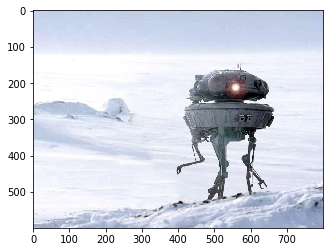

In [41]:
background_img = cv2.cvtColor(cv2.imread('samples/probe.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.close()
plt.imshow(background_img)

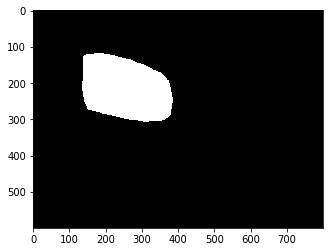

In [2]:
object_mask = cv2.cvtColor(cv2.imread('samples/polar_bear_mask.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_mask = np.mean(object_mask,axis=2)
object_mask[object_mask >= 0.5] = 1.
object_mask[object_mask < 0.5] = 0.
plt.close()
plt.imshow(object_mask,cmap='gray')

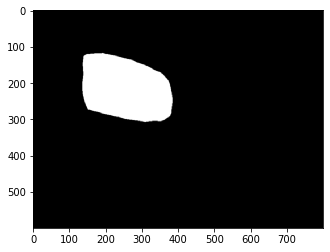

In [39]:
mask_l1 = blur_img(object_mask,kernel_size=5)
plt.close()
plt.imshow(mask_l1,cmap='gray')

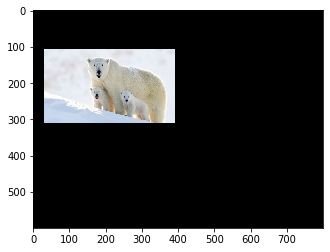

In [43]:
foreground_img = cv2.cvtColor(cv2.imread('samples/polar_bear_cropped.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.close()
plt.imshow(foreground_img)

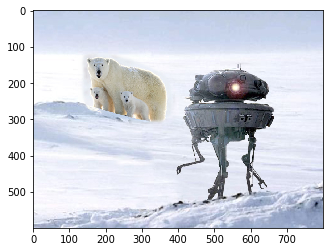

In [57]:
lap_blend = laplacian_blend(background_img, foreground_img, object_mask)
plt.close()
plt.imshow(lap_blend)
plt.imsave('laplacian_blend.jpg',lap_blend)

## More gradient domain processing (up to 20 pts)